# Notebook 02: NLP Transformation & Intent Discovery

## 1. Data Ingestion: Loading the Analytics Baseline
We start by loading the feature-engineered dataset from Notebook 01. This ensures our NLP pipeline operates on the exact same data used in our behavioral analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)

# Load the processed data
input_path = os.path.join('..', 'data', 'processed', 'analytics_base.csv')
df = pd.read_csv(input_path)

print(f"Dataset Loaded: {df.shape[0]} rows ready for NLP processing.")

Dataset Loaded: 1000 rows ready for NLP processing.


## 2. Environment Setup & Data Sanitization
Before vectorization, we must pass the text through the TextSanitizer to remove PII (Names, Emails). This step is critical for Before vectorization, all text is passed through the TextSanitizer pipeline to remove Personally Identifiable Information (PII).
This includes:

Emails and account IDs via high-precision regex filters, Human names via a Transformer-based Named Entity Recognition (bert-base-NER)

This hybrid approach combines deterministic pattern matching with context-aware deep learning, ensuring that private user data is removed even when it does not follow fixed formats.

This step is critical for ethical AI, privacy compliance, and model generalization, preventing downstream embedding models from memorizing or encoding real identities.

In [2]:
from src.preprocessing.cleaner import TextSanitizer 
sanitizer = TextSanitizer()

texts = df['clean_text'].tolist()

sanitized = sanitizer.batch_redact(texts)
sanitized = sanitizer.clean_batch(sanitized)

df['sanitized_text'] = sanitized

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /dslim/bert-base-NER/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 18c625b5-59c9-473e-94b5-8e76e59999a3)')' thrown while requesting HEAD https://huggingface.co/dslim/bert-base-NER/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /dslim/bert-base-NER/resolve/main/config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: b06c0877-71c9-4814-b59e-54faf13b93d5)')' thrown while requesting HEAD https://huggingface.co/dslim/bert-base-NER/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError(

## 3. High-Dimensional Vectorization using Transformers
We convert the sanitized text into 768-dimensional dense vectors using the all-mpnet-base-v2 transformer. These embeddings allow the system to "understand" semantic intent regardless of specific word choice.

In [3]:
from src.features.embeddings import VectorEngine

vector_engine = VectorEngine()
embeddings = vector_engine.generate_embeddings(df['sanitized_text'].tolist())

print(f"Vectorization Complete: Generated embedding matrix of shape {embeddings.shape}")

Generating embeddings for 1000 transcripts...


Batches: 100%|██████████| 32/32 [03:47<00:00,  7.10s/it]

Vectorization Complete: Generated embedding matrix of shape (1000, 768)


## 4. Dimensionality Reduction for Cluster Stability (UMAP)
To overcome the "Curse of Dimensionality," we use UMAP to project our vectors into a lower-dimensional space. This step concentrates the "density" of similar topics, making them discoverable by the clustering algorithm and merge it into our main dataframe.

In [5]:
import umap

reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.1,
    n_components=5,
    metric='cosine',
    random_state=42
)

umap_embeddings = reducer.fit_transform(embeddings)

print("UMAP Projection Complete: Dimensions reduced for clustering.")

UMAP Projection Complete: Dimensions reduced for clustering.


In [6]:
# Generate 2D coordinates specifically for the Streamlit Map
viz_reducer = umap.UMAP(n_components=2, n_neighbors=50, random_state=42)
umap_2d = viz_reducer.fit_transform(embeddings)

# Add to dataframe
df['x_coord'] = umap_2d[:, 0]
df['y_coord'] = umap_2d[:, 1]

# # Re-save the CSV
# df.to_csv('../data/processed/clustered_data.csv', index=False)
print("Coordinate data synced for Streamlit visualization.")

Coordinate data synced for Streamlit visualization.


## 5. Latent Intent Discovery with HDBSCAN
Using HDBSCAN, we discover "islands" of conversational density. Unlike K-Means, this density-based approach identifies natural clusters (Intent Archetypes) and separates outlier "Noise" from the core data patterns.

In [7]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100,
                            min_samples=15,
                            metric='euclidean',
                           cluster_selection_method='eom')

df['cluster_id'] = clusterer.fit_predict(umap_embeddings)

print(f"Clustering Complete: Identified {len(df['cluster_id'].unique())} unique intent archetypes.")

Clustering Complete: Identified 6 unique intent archetypes.


## 6. Visualizing the Call Archetypes
We project our findings into 2D space to verify the thematic separation of our clusters. This visualization serves as a primary stakeholder asset for explaining the call center's operational landscape.

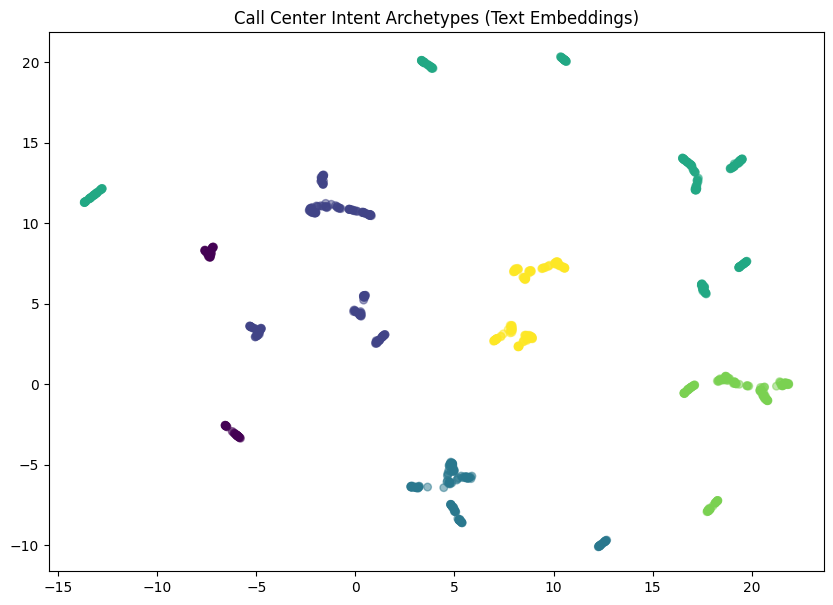

In [8]:
import matplotlib.pyplot as plt

viz_reducer = umap.UMAP(n_components=2, random_state=42)
viz_2d = viz_reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(viz_2d[:, 0], viz_2d[:, 1], c=df['cluster_id'], cmap='viridis', s=30, alpha=0.5)
plt.title('Call Center Intent Archetypes (Text Embeddings)')
plt.show()

## 7. Research Checkpoint: Persisting Clusters and Vectors
We save the clustered dataframe and the raw embedding matrix. This allows Notebook 03 to perform advanced performance validation without re-calculating the expensive transformer models.

In [9]:
# Save DataFrame
df.to_csv(os.path.join('..', 'data', 'processed', 'clustered_data.csv'), index=False)

# Save Embeddings (Binary)
np.save(os.path.join('..', 'data', 'embeddings', 'transcript_embeddings.npy'), embeddings)

print("Checkpoint 02 Complete: Clustered data and embeddings persisted.")

Checkpoint 02 Complete: Clustered data and embeddings persisted.


In [10]:
df.head()

,agent_id,duration_sec,csat_score,issue_category,customer_persona,clean_text,talk_ratio,turns_count,resolved,escalated,churned,hour_of_day,is_weekend,avg_word_per_turn,sanitized_text,x_coord,y_coord,cluster_id
0,AGENT_493,408,1,internet,elderly,The internet isn't working properly. I can't g...,1.33,12,False,False,True,7,0,34.00,the internet isn't working properly. i can't g...,-3.377386,2.233517,3
1,AGENT_653,669,1,internet,churn_risk,This is why I'm leaving - your service is unre...,1.08,18,False,True,True,5,0,37.17,this is why i'm leaving - your service is unre...,6.618243,7.446054,2
2,AGENT_745,1200,2,cancellation,elderly,I think I need to cancel some services. I don'...,1.16,18,False,False,False,20,0,66.67,i think i need to cancel some services. i don'...,2.400919,12.111226,2
3,AGENT_295,384,1,upgrade,angry,I want to upgrade but your process is so frust...,1.30,10,False,True,True,9,0,38.40,i want to upgrade but your process is so frust...,15.657031,6.556784,0
4,AGENT_165,297,1,device,angry,Your device doesn't work and your instructions...,0.94,8,False,True,True,1,0,37.12,your device doesn't work and your instructions...,3.072005,-4.591137,-1
